# Chess winner predictor

This is a chess winner predictor training program

In [ ]:
# Hyperparameters

learning_rate = 0.01
weight_decay_rate = 0.00001
training_epochs = 100
batch_size = 256
display_time_diff = 1.0

# Network Parameters

num_blocks = 6
res_block_filters = 64

## data loading and processing

In [2]:
with open("rawdata.txt", "r") as f:
    data = f.readlines()[5:1000000]

In [ ]:
import time

def process():
    processed = open("chess_processed_small.csv", "w")

    def convert_to_pgn(move_sequence):
        moves = move_sequence.split(" ")
        pgn_moves = []
        for i in range(0, len(moves), 2):
            move_number = i // 2 + 1
            white_move = moves[i].split('.')[1]
            black_move = moves[i+1].split('.')[1] if i + 1 < len(moves) and '.' in moves[i+1] else ''
            pgn_moves.append(f"{move_number}.{white_move} {black_move}")
        return " ".join(pgn_moves)

    _time = time.time()
    _processed = 0
    _total = 0
    processed.write("winner,white_elo,black_elo,diff,pgn\n")
    processed_cache = ""
    for line in data:
        metadata, pgn = line.split(" ### ")
        pgn = pgn.strip()
        metadata = metadata.strip()
        metadata = metadata.split(" ")
        winner = metadata[2]
        cond = metadata[3] != "None" and metadata[4] != "None" and int(metadata[3]) > 2500 and int(metadata[4]) > 2500
        if "blen_false" in metadata[15] and pgn.endswith("#") and cond:
            welo, belo = int(metadata[3]), int(metadata[4])
            pgn = convert_to_pgn(pgn)
            processed_cache += f"{1.0 if winner == '1-0' else -1.0},{welo},{belo},{welo - belo},{pgn}\n"
            _processed += 1
        _total += 1

        if time.time() - _time > 0.2:
            print(f"{_processed} / {_total}")
            _time = time.time()

        if _processed > 1000:
            break

    print("done")
    processed.write(processed_cache)
    processed.close()

process()

In [17]:
import pandas as pd
import io
import chess.pgn

df = pd.read_csv("chess_processed_small.csv")
df.head() # debug


,winner,white_elo,black_elo,diff,pgn
0,1,2838,2574,264,1.c4 e6 2.Nc3 d5 3.d4 Nf6 4.cxd5 exd5 5.Bg5 Be...
1,0,2802,2838,-36,1.d4 Nf6 2.c4 e6 3.Nf3 b6 4.e3 Bb7 5.Bd3 d5 6....
2,1,2801,2644,157,1.c4 c5 2.Nf3 Nf6 3.Nc3 Nc6 4.g3 d5 5.cxd5 Nxd...
3,1,2800,2610,190,1.c4 e5 2.Nc3 Nc6 3.g3 g6 4.Bg2 Bg7 5.Rb1 f5 6...
4,1,2800,2640,160,1.d4 Nf6 2.c4 c6 3.Nc3 g6 4.e4 d5 5.e5 Ne4 6.B...


## Data processing

In [18]:
import numpy as np

def board_to_array(board):
    board_state = np.zeros((6, 8, 8))

    piece_dict = {
        'P': 0,  # White Pawn
        'R': 1,  # White Rook
        'N': 2,  # White Knight
        'B': 3,  # White Bishop
        'Q': 4,  # White Queen
        'K': 5,  # White King
    }

    for i in range(8):
        for j in range(8):
            piece = board.piece_at(chess.square(i, j))

            if piece:
                piece_str = str(piece)
                color = int(piece_str.isupper())
                layer = piece_dict[piece_str.upper()]
                board_state[layer, 7-j, i] = color*2-1
            
    return board_state

def pgn_to_states(p):
    game_states = []

    p = io.StringIO(p)
    game = chess.pgn.read_game(p)
    p.close()

    board = game.board()
    for move in game.mainline_moves():
        board.push(move)
        board_state = board_to_array(board)
        game_states.append(board_state)

    return game_states


In [33]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class ResBlock(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
    
    def forward(self, x):
        x1 = self.convs(x)
        x1 += x
        return F.leaky_relu(x1)

class ChessNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            *[ResBlock() for _ in range(5)],
            nn.Flatten(),
            nn.Linear(64*8*8, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.convs(x)
    
    def predict(self, x):
        return self.forward(x).item()
    
class ChessDataset(Dataset):
    def __init__(self, df):
        self.states = []
        self.labels = []

        for idx, row in df.iterrows():
            states = pgn_to_states(row['pgn'])
            winner = row['winner']
            
            for state in states:
                self.states.append(torch.tensor(state, dtype=torch.float32))
                self.labels.append(torch.tensor(winner, dtype=torch.float32))
    
    def __len__(self):
        return len(self.states)
    
    def __getitem__(self, idx):
        return self.states[idx], self.labels[idx]

def train(model, optimizer, criterion, x, y):
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

train_split, test_split = train_test_split(df, test_size=0.2)

train_dataset = ChessDataset(train_split)
test_dataset = ChessDataset(test_split)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [96]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ChessNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay_rate)
criterion = nn.L1Loss()

In [99]:
loss_graph = []
val_graph = []

time_predictor = LinearRegression()
time_x = []
time_y = []
time_last = time.time()

for epoch in range(1, 11):
    print(f"Epoch {epoch}")
    loss = 0
    for i1, (x, y) in enumerate(train_loader):
        states = x.to(device)
        result = y.to(device).unsqueeze(dim=1)
        loss += train(model, optimizer, criterion, states, result)
        # loss += train(model, optimizer, criterion, torch.flip(states * -1, dims=[2]), result * -1)
        if (i1) % 30 == 0:
            val_graph.append(a())
            print(f"{i1} / {len(train_loader) * 2}")
            print(f"Loss: {loss / (i1 + 1)}")
            loss_graph.append(loss / (i1 + 1))
    

Epoch 1
Accuracy: 0.525
0 / 5734
Loss: 0.3715019226074219
Accuracy: 0.475
30 / 5734
Loss: 0.40638856061043277
Accuracy: 0.56
60 / 5734
Loss: 0.4074577483974519
Accuracy: 0.43
90 / 5734
Loss: 0.4016304235536974
Accuracy: 0.65
120 / 5734
Loss: 0.3936997080637404
Accuracy: 0.475
150 / 5734
Loss: 0.38976325716403937
Accuracy: 0.52
180 / 5734
Loss: 0.38550680941639687
Accuracy: 0.475
210 / 5734
Loss: 0.3840067758096903
Accuracy: 0.53
240 / 5734
Loss: 0.3832235379585092
Accuracy: 0.56
270 / 5734
Loss: 0.3823798751919032
Accuracy: 0.495
300 / 5734
Loss: 0.3802863254004539
Accuracy: 0.41
330 / 5734
Loss: 0.3766557970886144
Accuracy: 0.525
360 / 5734
Loss: 0.37602697560496606
Accuracy: 0.36
390 / 5734
Loss: 0.3753303664800761
Accuracy: 0.38
420 / 5734
Loss: 0.37313926301347955
Accuracy: 0.39
450 / 5734
Loss: 0.37180649186845893
Accuracy: 0.54
480 / 5734
Loss: 0.369470099680389
Accuracy: 0.555
510 / 5734
Loss: 0.36788533770874754
Accuracy: 0.44
540 / 5734
Loss: 0.36718244252936455
Accuracy: 0.44

KeyboardInterrupt: 

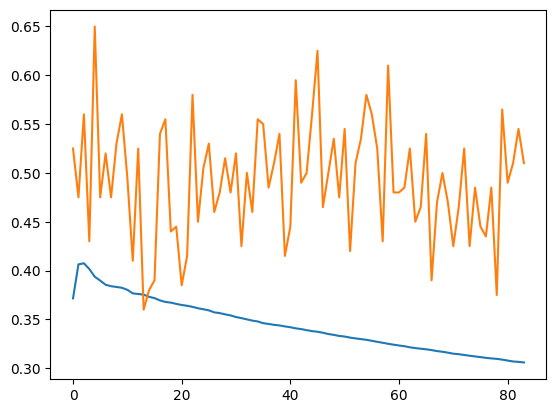

In [100]:
import matplotlib.pyplot as plt

plt.plot(loss_graph)
plt.plot(val_graph)
plt.show()

In [95]:
import random

def a():
    accuracy = 0

    for i in range(200):
        a = int(random.randrange(1, 1000))
        test = test_dataset[a][0]
        test = test.to(device).unsqueeze(0)
        if round(model.predict(test)) == round(test_dataset[a][1].item()):
            accuracy += 1

    print(f"Accuracy: {accuracy / 200}")
    return accuracy / 200

In [75]:
print(df.iat[0, 3])

264
